In [14]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 4.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install torch torchvision opencv-python matplotlib Pillow

Note: you may need to restart the kernel to use updated packages.


In [54]:
# STEP 1: Imports
import os
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from model import enhance_net_nopool  # model.py

# STEP 2: Configuration
input_dir = './test_data/low/'  # test images 
output_dir = './results/'
weights_path = './snapshots/Epoch99.pth'
os.makedirs(output_dir, exist_ok=True)

# STEP 3: Load the pretrained model
model = enhance_net_nopool(scale_factor=1)
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model.eval()

# STEP 4: Enhance images
transform = transforms.ToTensor()

for filename in os.listdir(input_dir):
    if not filename.lower().endswith(('.jpg', '.png')):
        continue
    path = os.path.join(input_dir, filename)
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        enhanced_img, _ = model(input_tensor)
        enhanced = enhanced_img.squeeze().permute(1, 2, 0).clamp(0, 1).numpy()
        enhanced = (enhanced * 255).astype('uint8')
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))


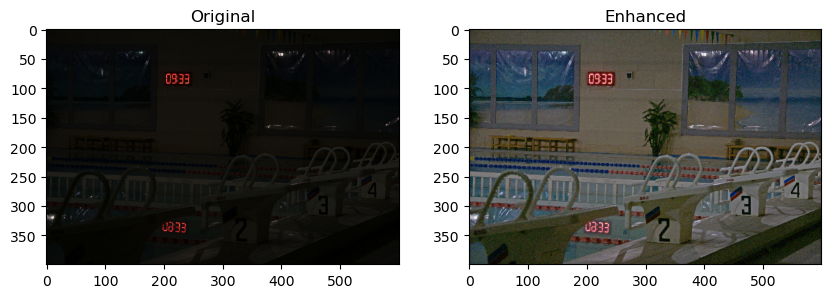

In [56]:
# Choose a filename to compare input and output
filename = '748.png'

original = cv2.cvtColor(cv2.imread(os.path.join(input_dir, filename)), cv2.COLOR_BGR2RGB)
enhanced = cv2.cvtColor(cv2.imread(os.path.join(output_dir, filename)), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(original); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(enhanced); plt.title("Enhanced")
plt.show()

In [58]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Read the ground truth (high-quality) image
gt = cv2.imread('./test_data/high/' + filename)
# Read the enhanced (output) image
enh = cv2.imread(os.path.join(output_dir, filename))

# Compute Peak Signal-to-Noise Ratio (PSNR) between the ground truth and enhanced image
psnr = peak_signal_noise_ratio(gt, enh)
# Compute Structural Similarity Index (SSIM) between the ground truth and enhanced image
ssim = structural_similarity(gt, enh, channel_axis=2)

print(f"PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

PSNR: 20.76, SSIM: 0.6399


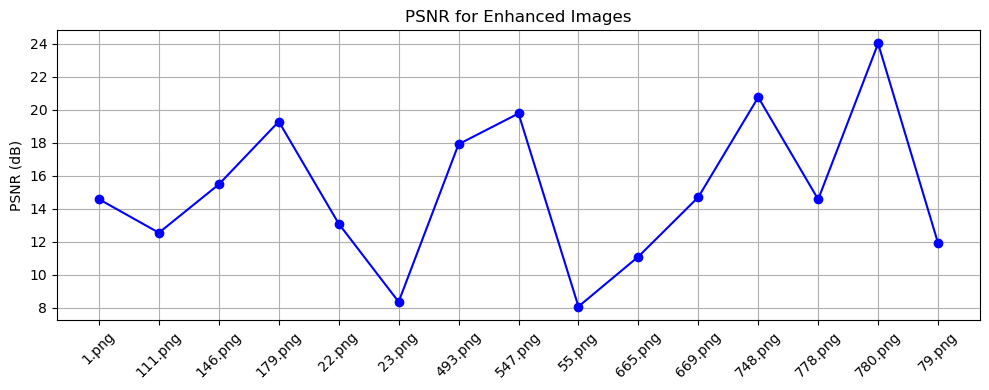

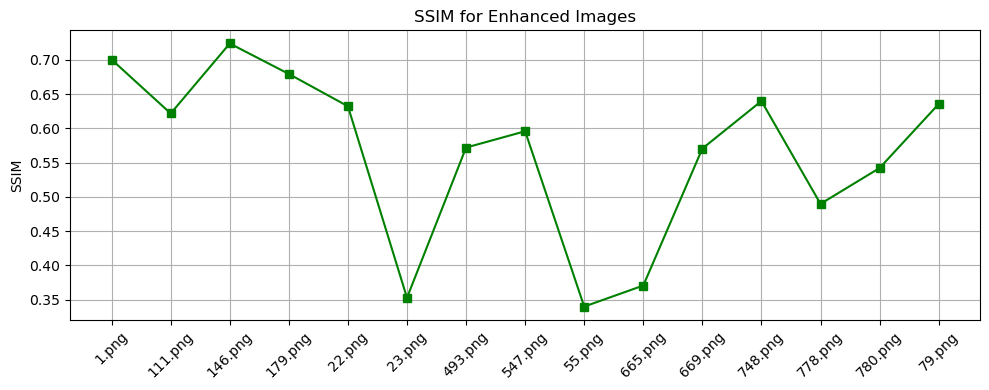

In [60]:
import os
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Directories
gt_dir = './test_data/high/'
enh_dir = './results/'

# Lists to store results
image_names = []
psnr_scores = []
ssim_scores = []

# Loop through enhanced images
for filename in os.listdir(enh_dir):
    if filename.endswith(('.jpg', '.png')):
        gt_path = os.path.join(gt_dir, filename)
        enh_path = os.path.join(enh_dir, filename)

        gt = cv2.imread(gt_path)
        enh = cv2.imread(enh_path)

        if gt is None or enh is None:
            continue

        # Resize to match
        gt = cv2.resize(gt, (enh.shape[1], enh.shape[0]))
        gt_rgb = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
        enh_rgb = cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)

        # Compute metrics
        psnr = peak_signal_noise_ratio(gt_rgb, enh_rgb)
        ssim = structural_similarity(gt_rgb, enh_rgb, channel_axis=2)

        # Store
        image_names.append(filename)
        psnr_scores.append(psnr)
        ssim_scores.append(ssim)

# Sort results for consistent plotting
sorted_data = sorted(zip(image_names, psnr_scores, ssim_scores), key=lambda x: x[0])
image_names, psnr_scores, ssim_scores = zip(*sorted_data)

# Plot PSNR
plt.figure(figsize=(10, 4))
plt.plot(image_names, psnr_scores, marker='o', linestyle='-', color='blue', label='PSNR (dB)')
plt.xticks(rotation=45)
plt.ylabel("PSNR (dB)")
plt.title("PSNR for Enhanced Images")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot SSIM
plt.figure(figsize=(10, 4))
plt.plot(image_names, ssim_scores, marker='s', linestyle='-', color='green', label='SSIM')
plt.xticks(rotation=45)
plt.ylabel("SSIM")
plt.title("SSIM for Enhanced Images")
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Define folders
gt_folder = './test_data/high/'          # ground truth (well-lit images)
enh_folder = './results/'          # enhanced images by Zero-DCE++

# Get list of enhanced image files
files = sorted([f for f in os.listdir(enh_folder) if f.endswith('.png')])
psnr_values = []
ssim_values = []

for filename in files:
    # Load images
    gt_path = os.path.join(gt_folder, filename)
    enh_path = os.path.join(enh_folder, filename)
    
    gt = cv2.imread(gt_path)
    enh = cv2.imread(enh_path)

    # Convert to RGB
    gt_rgb = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    enh_rgb = cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)

    # Compute metrics
    psnr = peak_signal_noise_ratio(gt_rgb, enh_rgb, data_range=255)
    ssim = structural_similarity(gt_rgb, enh_rgb, channel_axis=2)

    psnr_values.append(psnr)
    ssim_values.append(ssim)

# Print result
for f, p, s in zip(files, psnr_values, ssim_values):
    print(f"{f}: PSNR = {p:.2f} dB, SSIM = {s:.4f}")


1.png: PSNR = 14.58 dB, SSIM = 0.7004
111.png: PSNR = 12.54 dB, SSIM = 0.6218
146.png: PSNR = 15.48 dB, SSIM = 0.7239
179.png: PSNR = 19.29 dB, SSIM = 0.6795
22.png: PSNR = 13.09 dB, SSIM = 0.6323
23.png: PSNR = 8.35 dB, SSIM = 0.3528
493.png: PSNR = 17.92 dB, SSIM = 0.5720
547.png: PSNR = 19.78 dB, SSIM = 0.5958
55.png: PSNR = 8.07 dB, SSIM = 0.3400
665.png: PSNR = 11.10 dB, SSIM = 0.3706
669.png: PSNR = 14.71 dB, SSIM = 0.5706
748.png: PSNR = 20.76 dB, SSIM = 0.6399
778.png: PSNR = 14.57 dB, SSIM = 0.4898
780.png: PSNR = 24.03 dB, SSIM = 0.5421
79.png: PSNR = 11.92 dB, SSIM = 0.6355


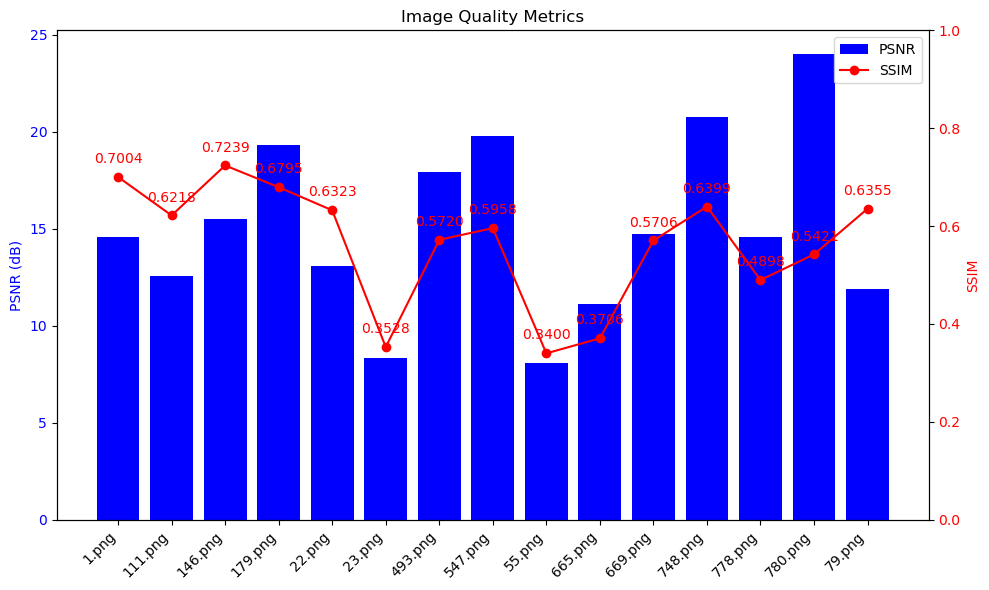

In [64]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Define folders
gt_folder = './test_data/high/'          # ground truth (well-lit images)
enh_folder = './results/'          # enhanced images by Zero-DCE++

# Collect filenames
files = sorted([f for f in os.listdir(enh_folder) if f.endswith('.png')])

psnr_values = []
ssim_values = []

# Calculate PSNR and SSIM for each file
for filename in files:
    gt_img = cv2.imread(os.path.join(gt_folder, filename))
    enh_img = cv2.imread(os.path.join(enh_folder, filename))

    # Convert to RGB
    gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    enh_rgb = cv2.cvtColor(enh_img, cv2.COLOR_BGR2RGB)

    # Compute metrics
    psnr = peak_signal_noise_ratio(gt_rgb, enh_rgb, data_range=255)
    ssim = structural_similarity(gt_rgb, enh_rgb, channel_axis=2)

    psnr_values.append(psnr)
    ssim_values.append(ssim)

# Plot the results
x = np.arange(len(files))

fig, ax1 = plt.subplots(figsize=(10, 6))

# PSNR Bar chart
ax1.bar(x, psnr_values, color='blue', label='PSNR')
ax1.set_ylabel('PSNR (dB)', color='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(files, rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor='blue')

# SSIM Line chart (right axis)
ax2 = ax1.twinx()
ax2.plot(x, ssim_values, color='red', marker='o', label='SSIM')
ax2.set_ylabel('SSIM', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1)

# Annotate each SSIM point
for i, val in enumerate(ssim_values):
    ax2.annotate(f"{val:.4f}", (x[i], ssim_values[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red')
    
# add legends
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Title
plt.title('Image Quality Metrics')

# Layout and show
fig.tight_layout()
plt.show()
